Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:
if example_name == "uci wine example":
    # read data and set scale of system
    features_frame = pd.read_csv("uci_wine_example_features.csv")
    features_scores = pd.read_csv("uci_wine_example_scores.csv")
    score_name = "quality"
    m_examples: int = 100
    noise_scale = 0.87
    position_penalty_scale = -0.7123
elif example_name == "sklearn wine example":
    # read data and set scale of system
    features_frame = pd.read_csv("sklearn_wine_example_features.csv")
    features_scores = pd.read_csv("sklearn_wine_example_scores.csv")
    score_name = "score"
    m_examples: int = 100
    noise_scale = 18.7
    position_penalty_scale = -13.123
else:
    raise ("bad option")

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties

[-0.0, -0.7123, -1.4246, -2.1369000000000002, -2.8492]

In [13]:
# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
    observations[f"display_position_{sel_i}"] = [sel_i] * m_examples
    selected_examples = rng.choice(
        features_frame.shape[0], size=m_examples, replace=True
    )
    observations[f"item_id_{sel_i}"] = selected_examples
    observations[f"score_value_{sel_i}"] = (
        [  # noisy observation of score plus position penalty
            features_scores.loc[int(selected_examples[i]), score_name]  # item score
            + position_penalties[sel_i]  # positional penalty
            + noise_scale * rng.normal(size=1)[0]  # observation noise
            for i in range(m_examples)
        ]
    )
    observations[f"pick_value_{sel_i}"] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
    best_j = 0
    for j in range(1, n_alternatives):
        if (
            observations[f"score_value_{j}"][i]
            > observations[f"score_value_{best_j}"][i]
        ):
            best_j = j
    observations.loc[i, f"pick_value_{best_j}"] = 1
observations

,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,0,1569,5.019845,0,1,1754,4.088608,0,2,6425,5.642813,1,3,2780,2.711379,0,4,2646,2.484459,0
1,0,4390,5.342953,0,1,2031,5.789340,0,2,2692,6.305606,1,3,4416,5.687387,0,4,1913,3.695064,0
2,0,599,6.662704,1,1,1808,5.444475,0,2,64,3.266001,0,3,59,3.826766,0,4,1671,1.551335,0
3,0,1392,4.772242,1,1,2324,3.444131,0,2,5815,2.939887,0,3,1819,4.016096,0,4,4567,2.596922,0
4,0,2063,5.015194,1,1,6283,3.813908,0,2,3610,4.497815,0,3,2085,2.881709,0,4,5610,4.512303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,4428,3.578106,0,1,6181,5.391424,1,2,1583,3.702214,0,3,1653,4.917610,0,4,1098,3.421113,0
96,0,804,5.803336,1,1,4323,4.790581,0,2,3548,3.962359,0,3,4637,3.534063,0,4,798,4.192741,0
97,0,1483,4.864124,0,1,1270,5.861899,1,2,3348,5.550363,0,3,5643,5.394233,0,4,3384,3.608275,0
98,0,555,5.079768,1,1,1235,3.650364,0,2,905,3.778933,0,3,6382,4.312935,0,4,3148,3.069520,0


In [14]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations,
            features_frame=features_frame,
        )

In [15]:
# make sure we don't have a column we would not know in practice
observations = observations.loc[
    :, [c for c in observations.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,0,1,1754,0,2,6425,1,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,1,1,6283,0,2,3610,0,3,2085,0,4,5610,0


In [16]:
observations.loc[
    :, [c for c in observations.columns if c.startswith("pick_value_")]
].mean(axis=0)

pick_value_0    0.48
pick_value_1    0.27
pick_value_2    0.14
pick_value_3    0.08
pick_value_4    0.03
dtype: float64

In [17]:
# This is the data
observations[
    [c for c in observations.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,0,1754,0,6425,1,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,1,6283,0,3610,0,2085,0,5610,0
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,1,1374,0,312,0,926,0,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [18]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [19]:
observations_sorted = sort_observations_frame(observations)

In [20]:
observations_sorted.head(10)

,encoding_0,item_id_0,pick_value_0,encoding_1,item_id_1,pick_value_1,encoding_2,item_id_2,pick_value_2,encoding_3,item_id_3,pick_value_3,encoding_4,item_id_4,pick_value_4
0,2,6425,1,1,1754,0,0,1569,0,3,2780,0,4,2646,0
1,2,2692,1,1,2031,0,0,4390,0,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,1,1,6283,0,2,3610,0,3,2085,0,4,5610,0
5,0,2010,1,1,1465,0,2,6388,0,3,25,0,4,420,0
6,0,5903,1,1,1374,0,2,312,0,3,926,0,4,5467,0
7,0,5194,1,1,3651,0,2,1494,0,3,1749,0,4,5865,0
8,0,5946,1,1,4527,0,2,5988,0,3,3021,0,4,4821,0
9,0,6469,1,1,6044,0,2,2787,0,3,5786,0,4,3709,0


In [21]:
observations_sorted[
    [c for c in observations_sorted.columns if not c.startswith("pick_value_")]
].head(10)

,encoding_0,item_id_0,encoding_1,item_id_1,encoding_2,item_id_2,encoding_3,item_id_3,encoding_4,item_id_4
0,2,6425,1,1754,0,1569,3,2780,4,2646
1,2,2692,1,2031,0,4390,3,4416,4,1913
2,0,599,1,1808,2,64,3,59,4,1671
3,0,1392,1,2324,2,5815,3,1819,4,4567
4,0,2063,1,6283,2,3610,3,2085,4,5610
5,0,2010,1,1465,2,6388,3,25,4,420
6,0,5903,1,1374,2,312,3,926,4,5467
7,0,5194,1,3651,2,1494,3,1749,4,5865
8,0,5946,1,4527,2,5988,3,3021,4,4821
9,0,6469,1,6044,2,2787,3,5786,4,3709


In [22]:
assert np.all(observations_sorted["pick_value_0"] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f"pick_value_{sel_i}"] == 0)

In [23]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_panel_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [24]:
data_str = format_Stan_data(
    observations_sorted=observations_sorted,
    features_frame=features_frame,
)

In [25]:
fit = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
)

In [26]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-146.016
1,-140.039
2,-145.607
3,-156.644
4,-144.434
...,...
3995,-140.765
3996,-146.951
3997,-146.034
3998,-151.649


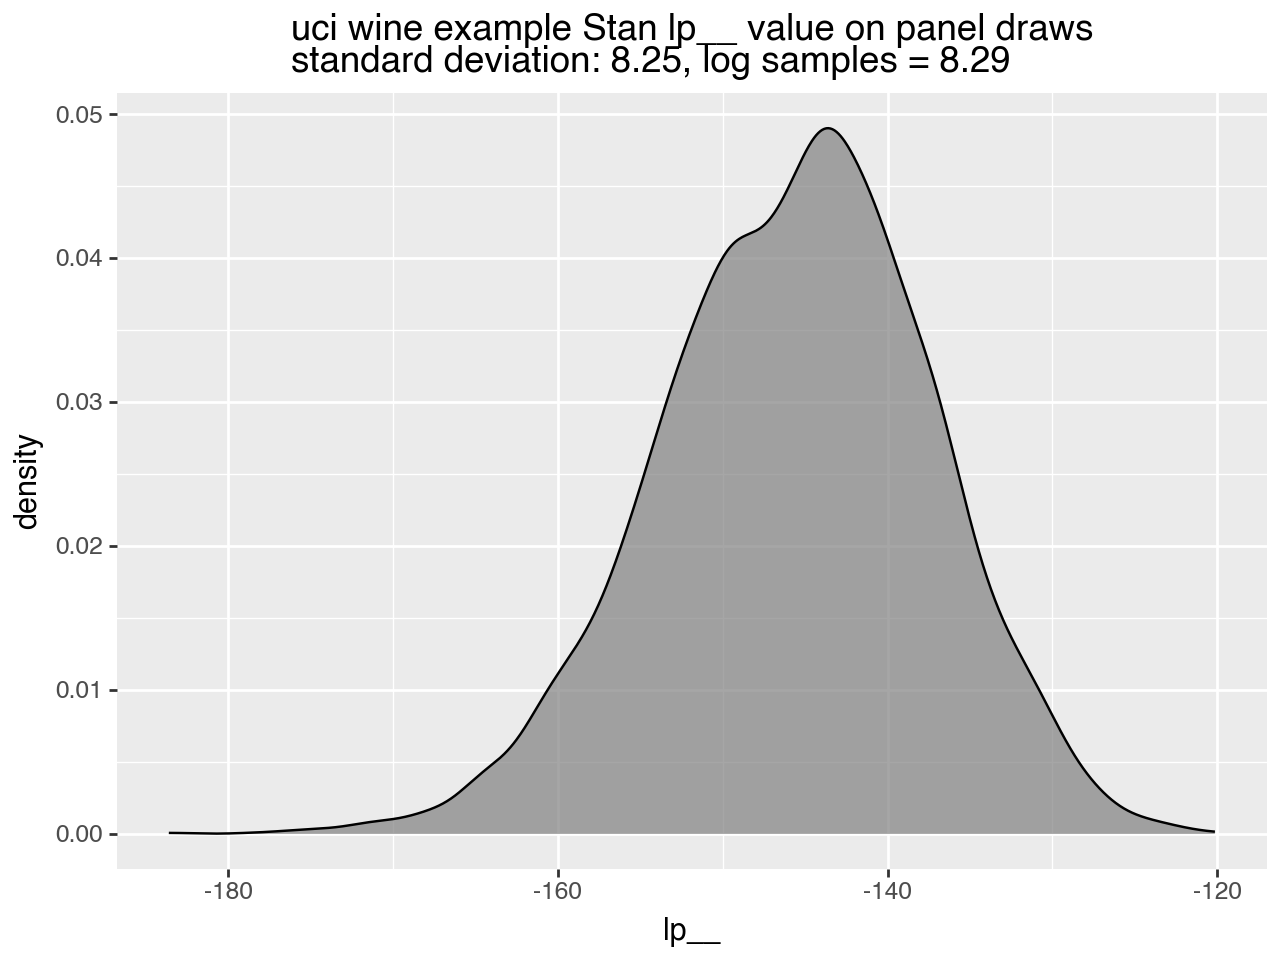

In [27]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [28]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [
    f"position_effect_{sel_i}" for sel_i in range(n_alternatives)
]

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,2.725200,4.651750,-12.17550,-1.896220,-5.046390,0.108447,-0.164538,6.13953,-9.666220,3.923500,...,-23.35560,3.185380,0.58991,2.85456,13.11110,6.36327,1.546530,-2.611490,-8.99260,-10.21690
1,0.852578,-0.391641,-14.49110,1.083740,-14.350700,0.393650,-0.180762,15.73210,-6.106670,9.728130,...,-16.50240,-3.069450,7.21329,3.76426,-3.35977,9.15485,0.941335,-4.345380,-6.19638,-11.91030
2,2.807160,3.006630,-21.03090,-2.399760,0.270182,-0.334636,0.102556,-14.57260,15.477400,17.394600,...,6.18637,4.274170,-7.82956,6.08414,7.43726,8.23749,3.091630,-4.950300,-6.43447,-13.45300
3,2.701860,-17.387600,-14.25560,-0.042061,1.981850,0.325400,-0.158812,17.83110,-6.192360,0.693085,...,6.44435,-3.548050,2.04787,4.00914,-2.22890,8.42881,-0.786330,0.183025,-5.47304,-13.15970
4,2.578090,18.522700,-2.53875,-1.443630,9.093410,0.443360,-0.038376,-5.95601,0.583226,8.192600,...,2.52872,2.224660,10.80190,4.81517,-3.96786,4.81827,0.140290,-6.232110,-6.76752,-10.93100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2.655130,6.944910,-10.96810,-4.528820,-5.491920,0.029404,-0.024764,3.51051,-3.398360,20.417200,...,6.40035,-1.229400,-2.61613,3.24729,-16.85130,17.06300,10.009900,0.509807,4.56445,-3.44012
3996,0.682510,-10.087600,-13.72300,1.081780,-1.064060,0.437950,-0.176291,1.41609,-7.467970,-1.829590,...,-9.37068,0.848257,-2.33590,5.44263,25.01680,3.92957,-4.240060,-6.771580,-8.28003,-13.75510
3997,0.840721,-14.404600,-6.58541,0.522029,-0.566016,0.402422,-0.200948,5.74964,-8.547470,-4.206560,...,-6.04569,-4.052620,-7.22516,5.22295,21.98460,3.73502,-3.642920,-5.149470,-12.58480,-10.08410
3998,4.623910,14.944000,-16.49510,-0.857520,-2.481330,0.016243,-0.111189,4.65642,2.776710,10.752500,...,8.55806,0.056334,2.34619,4.35563,-13.36060,28.44980,21.135600,15.933700,12.87110,7.89518


In [29]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.9), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red              2.762512
volatile acidity is red           0.837338
citric acid is red              -12.531075
residual sugar is red            -1.017356
chlorides is red                 -0.854106
free sulfur dioxide is red        0.131496
total sulfur dioxide is red      -0.099411
density is red                    2.533320
pH is red                        -0.459437
sulphates is red                  7.380256
alcohol is red                    1.904700
fixed acidity is white           -1.459668
volatile acidity is white       -12.102708
citric acid is white             -1.154734
residual sugar is white           0.593567
chlorides is white               -0.782848
free sulfur dioxide is white      0.051713
total sulfur dioxide is white    -0.008146
density is white                 -2.169792
pH is white                       0.040814
sulphates is white                2.090290
alcohol is white                  4.738626
is_red                            1.473773
position_ef

In [30]:
position_quantiles = (
    beta_draws.iloc[:, features_frame.shape[1] : n_vars]
    .quantile((0.25, 0.5, 0.75))
    .transpose()
    .reset_index(drop=True, inplace=False)
)
position_quantiles.columns = [str(c) for c in position_quantiles.columns]

estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,10.973146,-0.0000,7.805013,11.001250,14.227950
1,posn_1,4.073887,-0.7123,0.842672,3.920145,7.346940
2,posn_2,-0.073336,-1.4246,-3.781310,-0.611055,2.730328
3,posn_3,-4.076600,-2.1369,-7.968340,-4.508885,-1.195943
4,posn_4,-8.956754,-2.8492,-12.996475,-9.481505,-6.056355


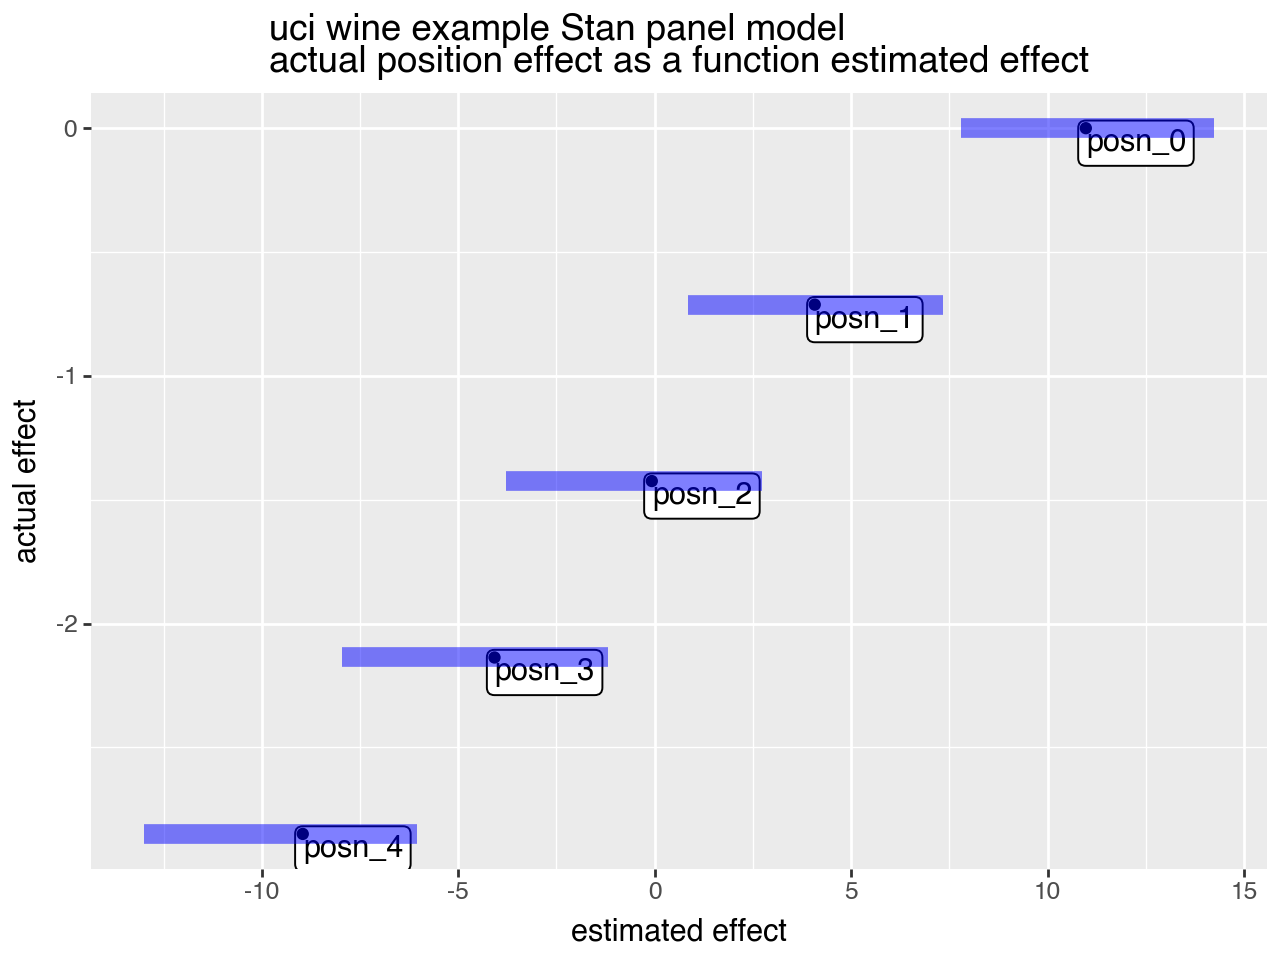

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6584,False
1,0,1,0.1429,False
2,0,2,0.1553,True
3,0,3,0.0334,False
4,0,4,0.0100,False
5,1,0,0.3894,False
6,1,1,0.1631,False
7,1,2,0.1202,True
8,1,3,0.2989,False
9,1,4,0.0284,False


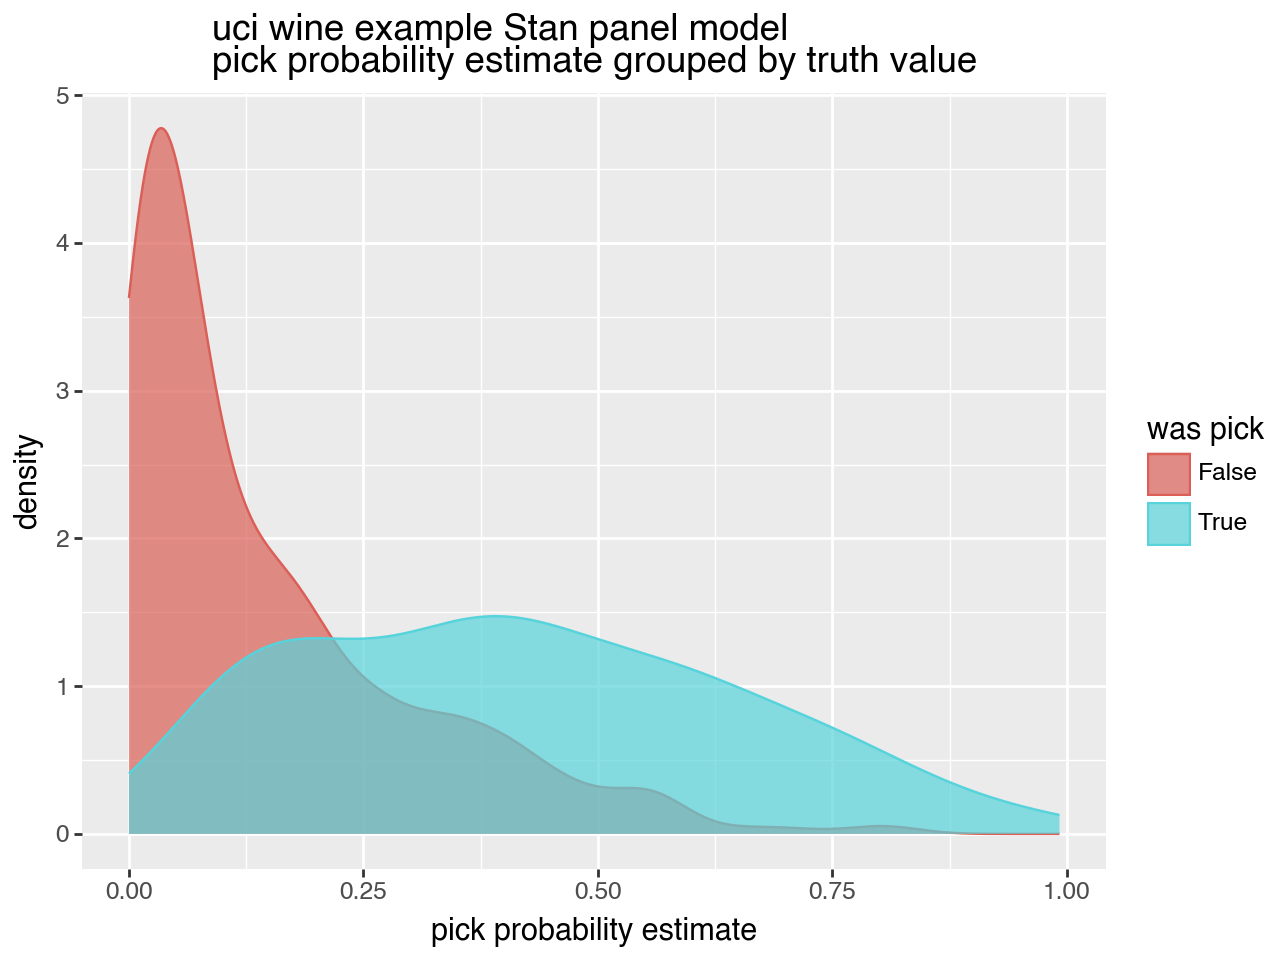

<Figure size 640x480 with 0 Axes>

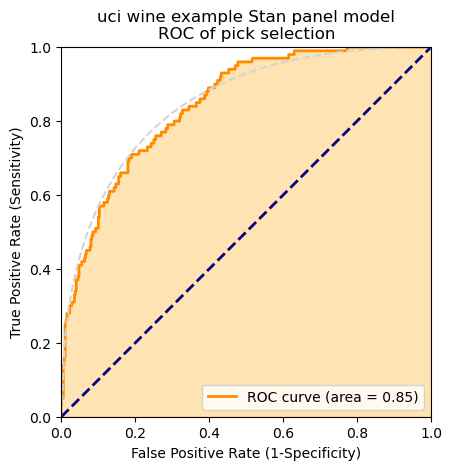

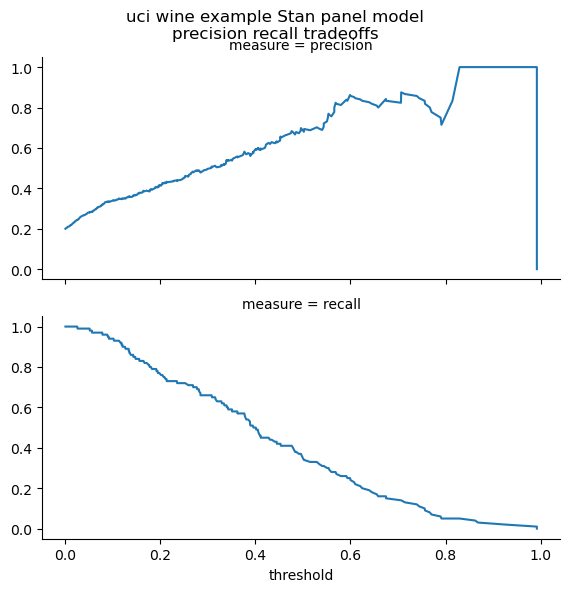

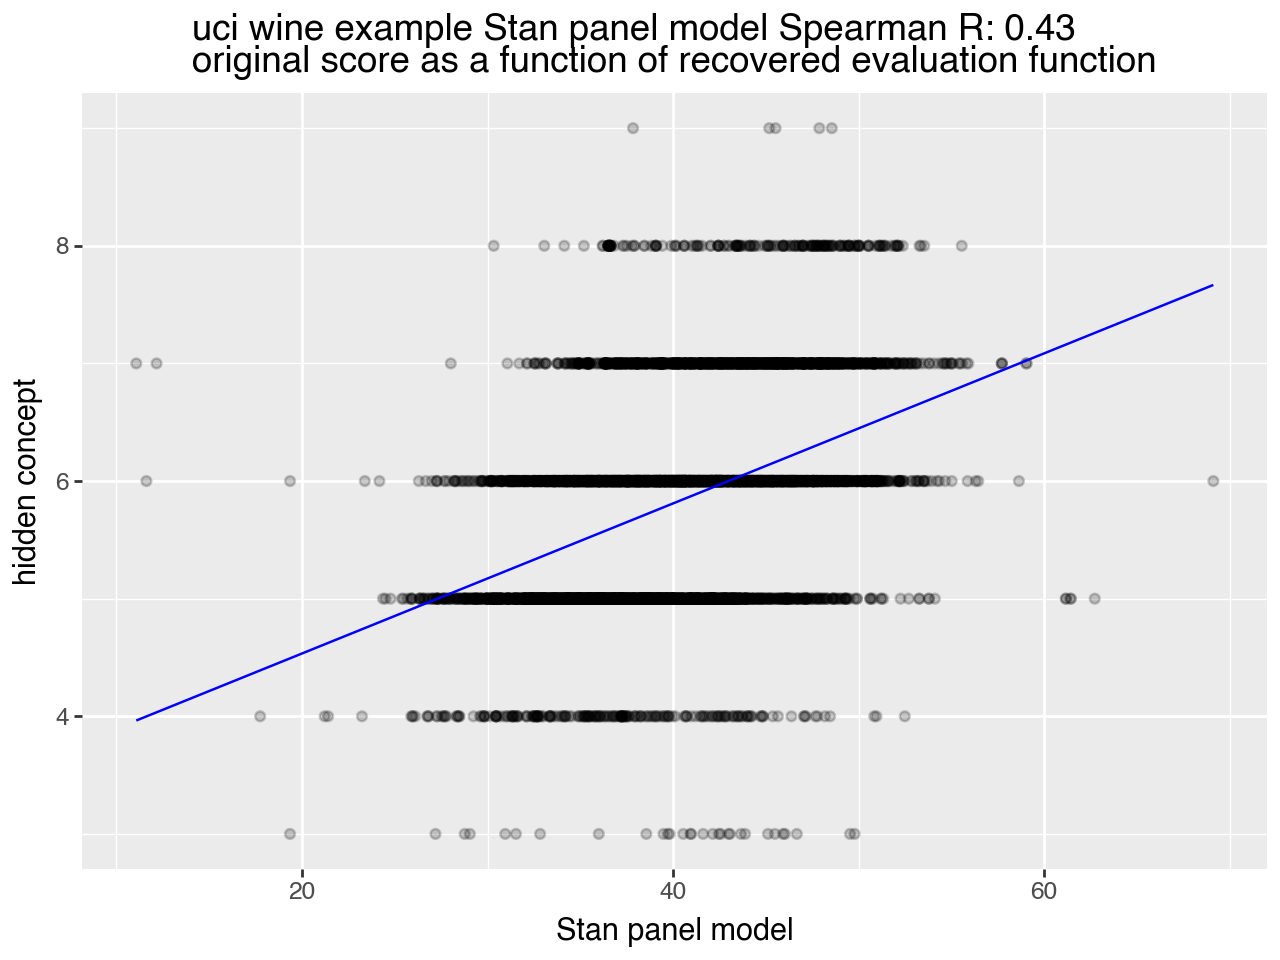

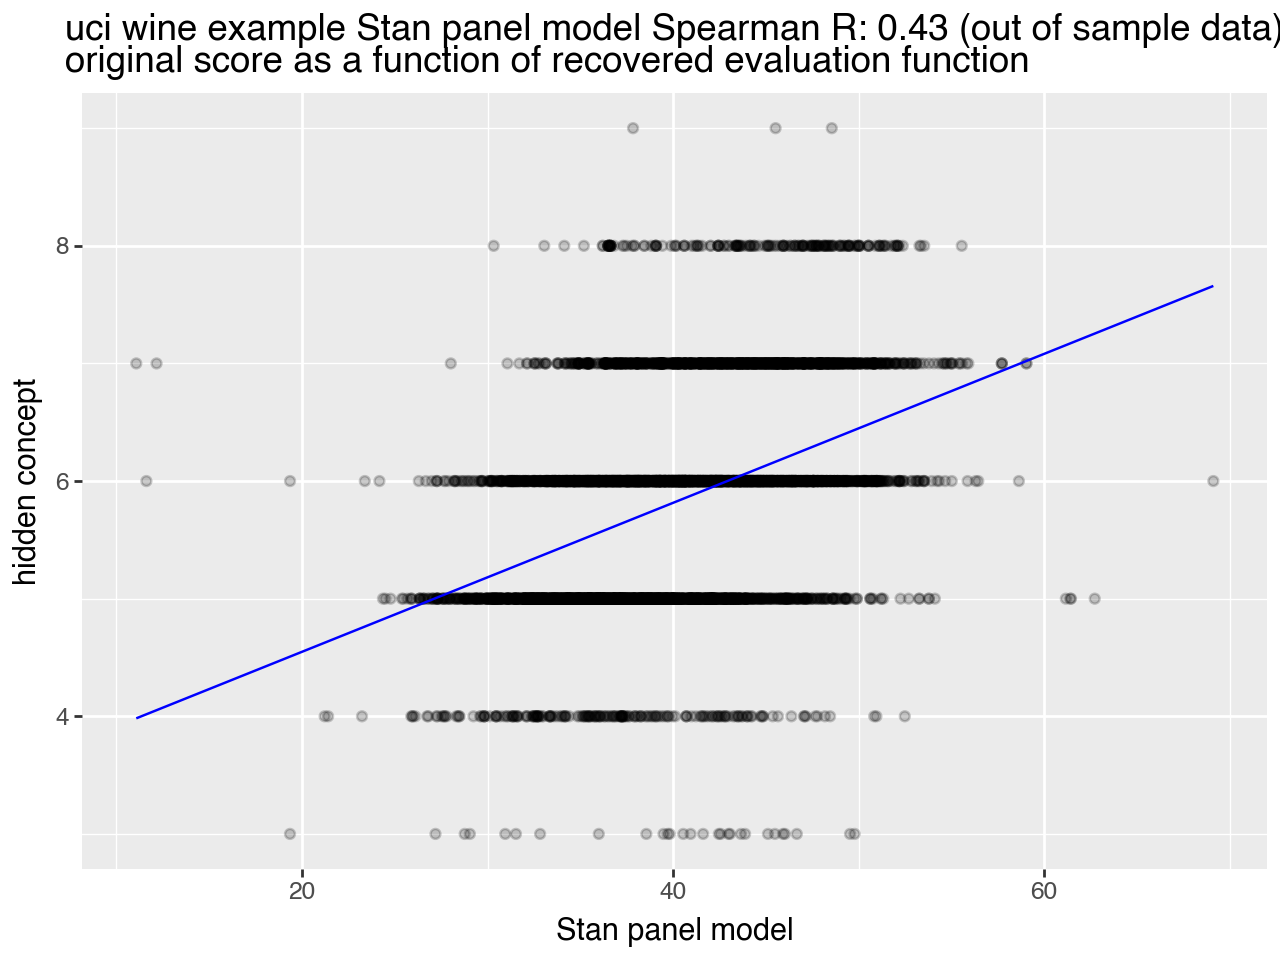

In [31]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan,  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="Stan panel model",  # display name of estimate
    position_quantiles=position_quantiles,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a logistic model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [32]:
feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations.shape[0]):
    feature_row = observations.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = (
                list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                )
                + posn_vec
            )
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [33]:
enc_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_0,position_1,position_2,position_3,position_4
0,-6.2,-0.51,-0.14,-1.9,-0.056,-15.0,-34.0,-0.99396,-3.48,-0.57,...,0.99462,3.48,0.57,10.7,-1.0,-1.0,0.0,1.0,0.0,0.0
1,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,...,-0.00328,0.59,0.15,1.8,0.0,0.0,-1.0,1.0,0.0,0.0
2,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,...,-0.00138,0.36,0.21,0.6,0.0,0.0,0.0,1.0,-1.0,0.0
3,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,...,0.00282,0.41,0.14,0.3,0.0,0.0,0.0,1.0,0.0,-1.0
4,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,...,-0.00154,-0.12,-0.17,1.4,0.0,-1.0,0.0,1.0,0.0,0.0


In [34]:
logistic_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
logistic_model.fit(
    pd.concat([enc_frame, -enc_frame], ignore_index=True),
    [True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

estimated position influences


,position,estimated effect,actual effect
0,posn_0,1.558515,-0.0000
1,posn_1,0.613909,-0.7123
2,posn_2,-0.052073,-1.4246
3,posn_3,-0.676485,-2.1369
4,posn_4,-1.443866,-2.8492


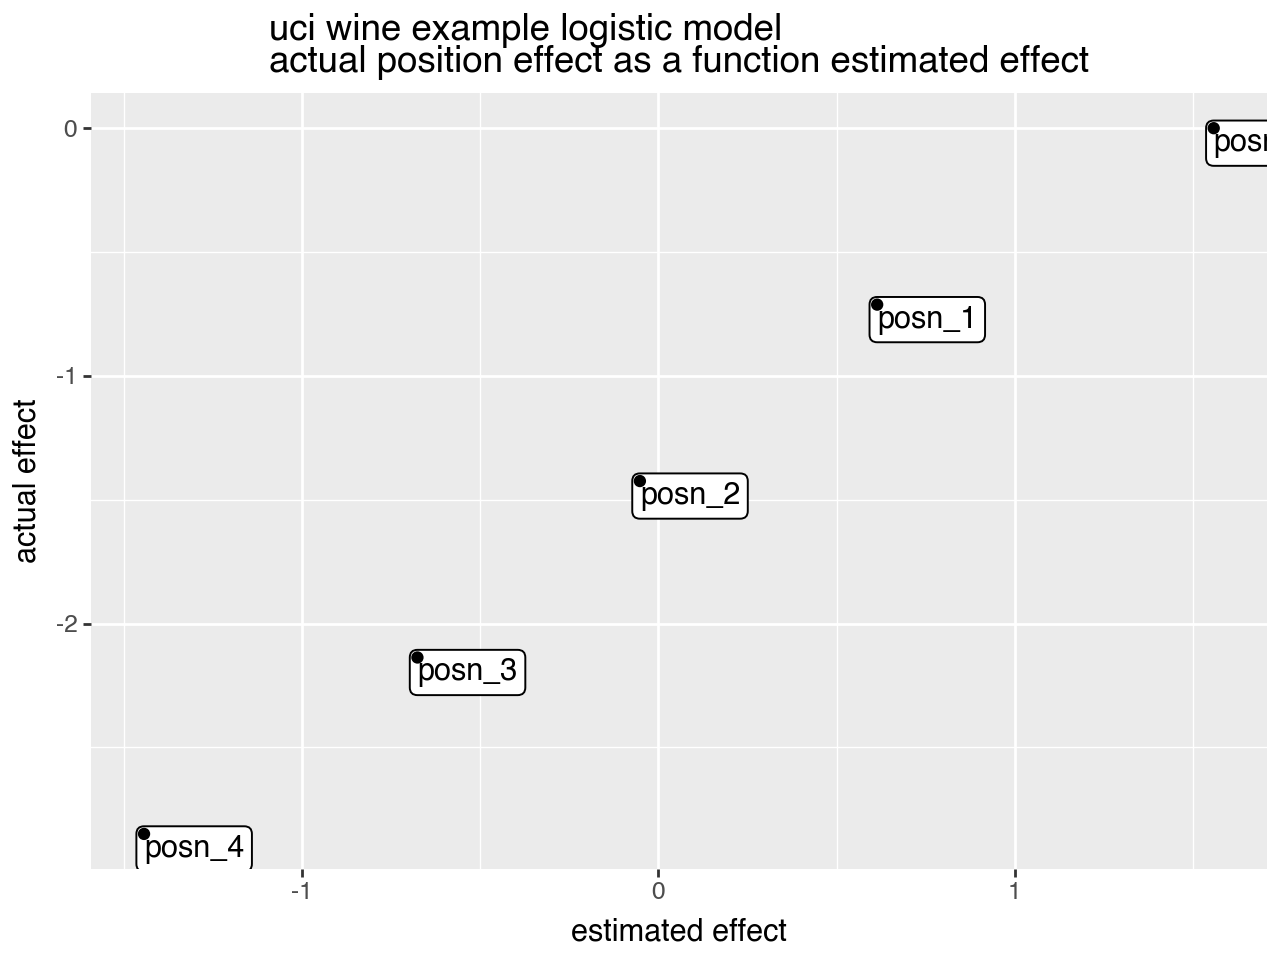

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2544,False
1,0,1,0.2205,False
2,0,2,0.2095,True
3,0,3,0.1722,False
4,0,4,0.1434,False
5,1,0,0.2281,False
6,1,1,0.2022,False
7,1,2,0.1985,True
8,1,3,0.2182,False
9,1,4,0.1530,False


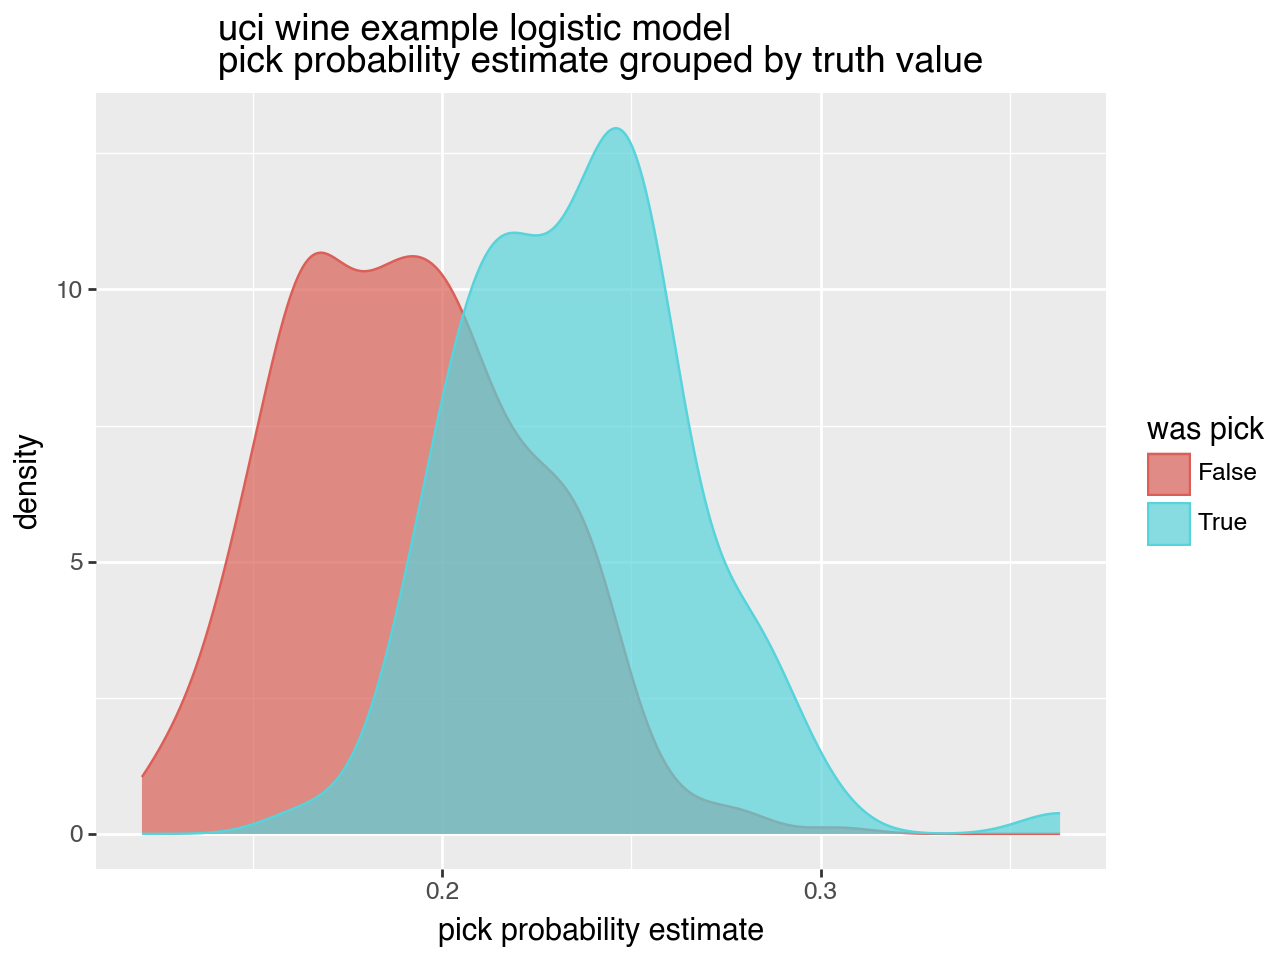

<Figure size 640x480 with 0 Axes>

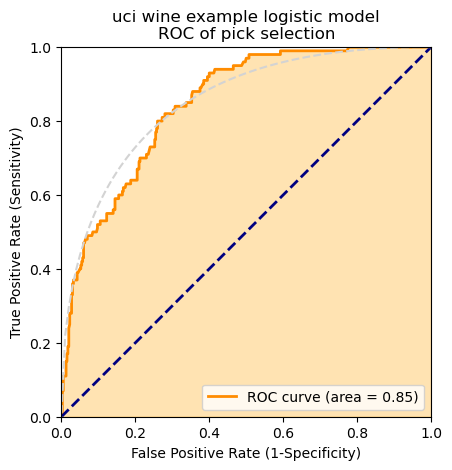

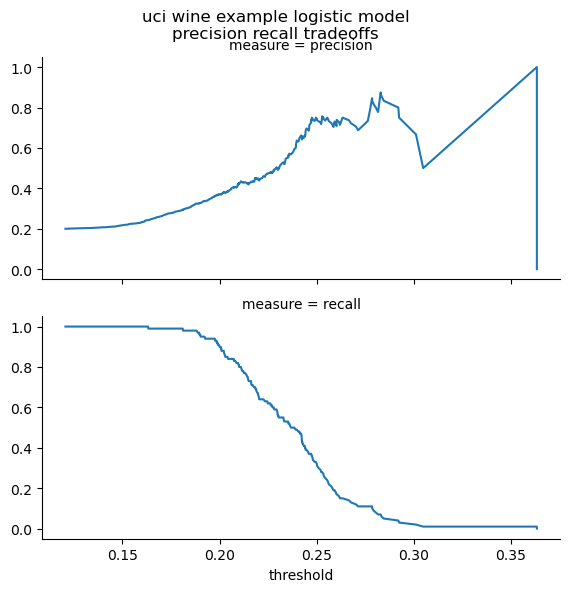

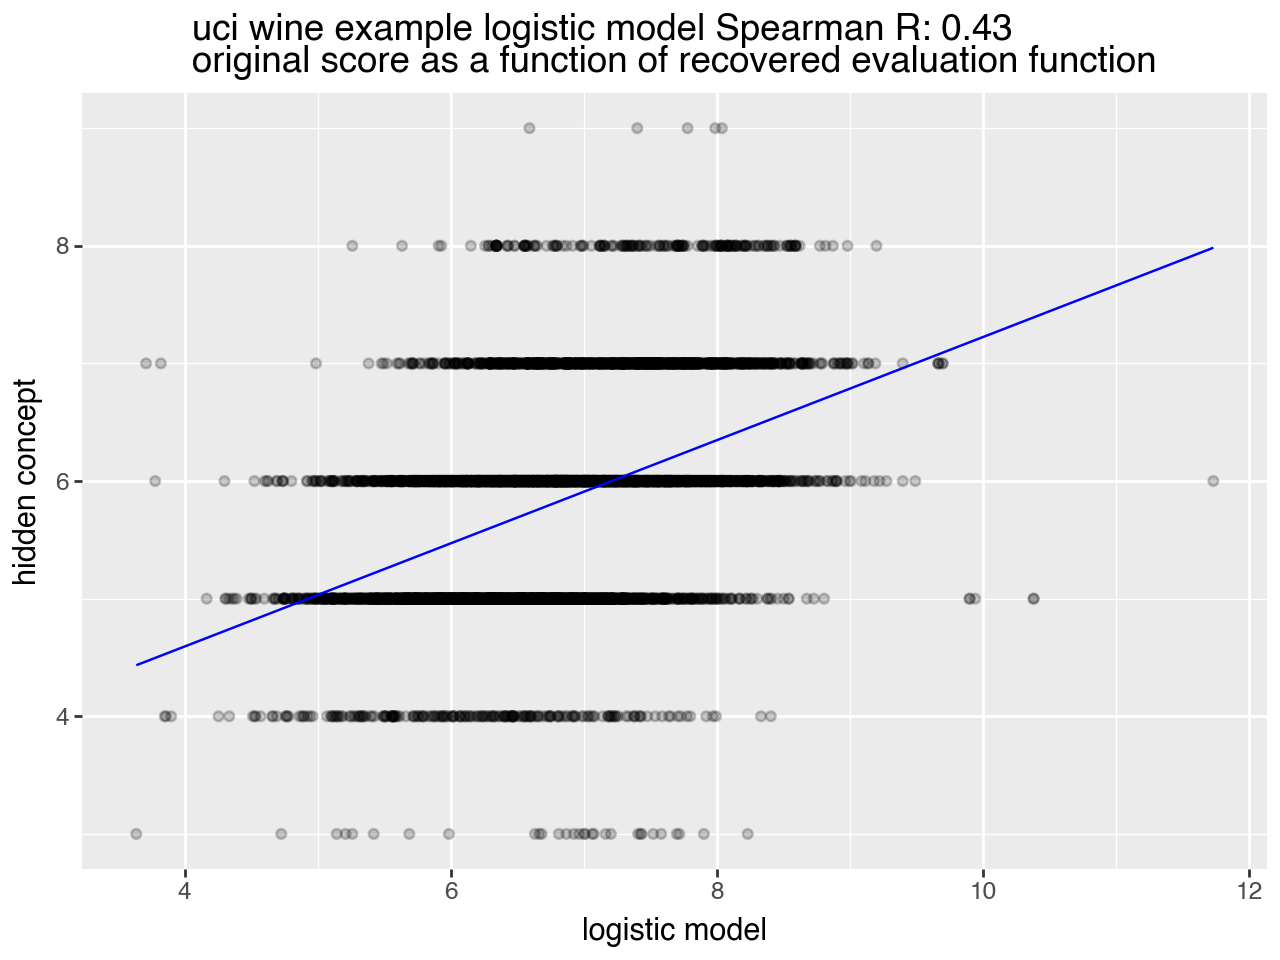

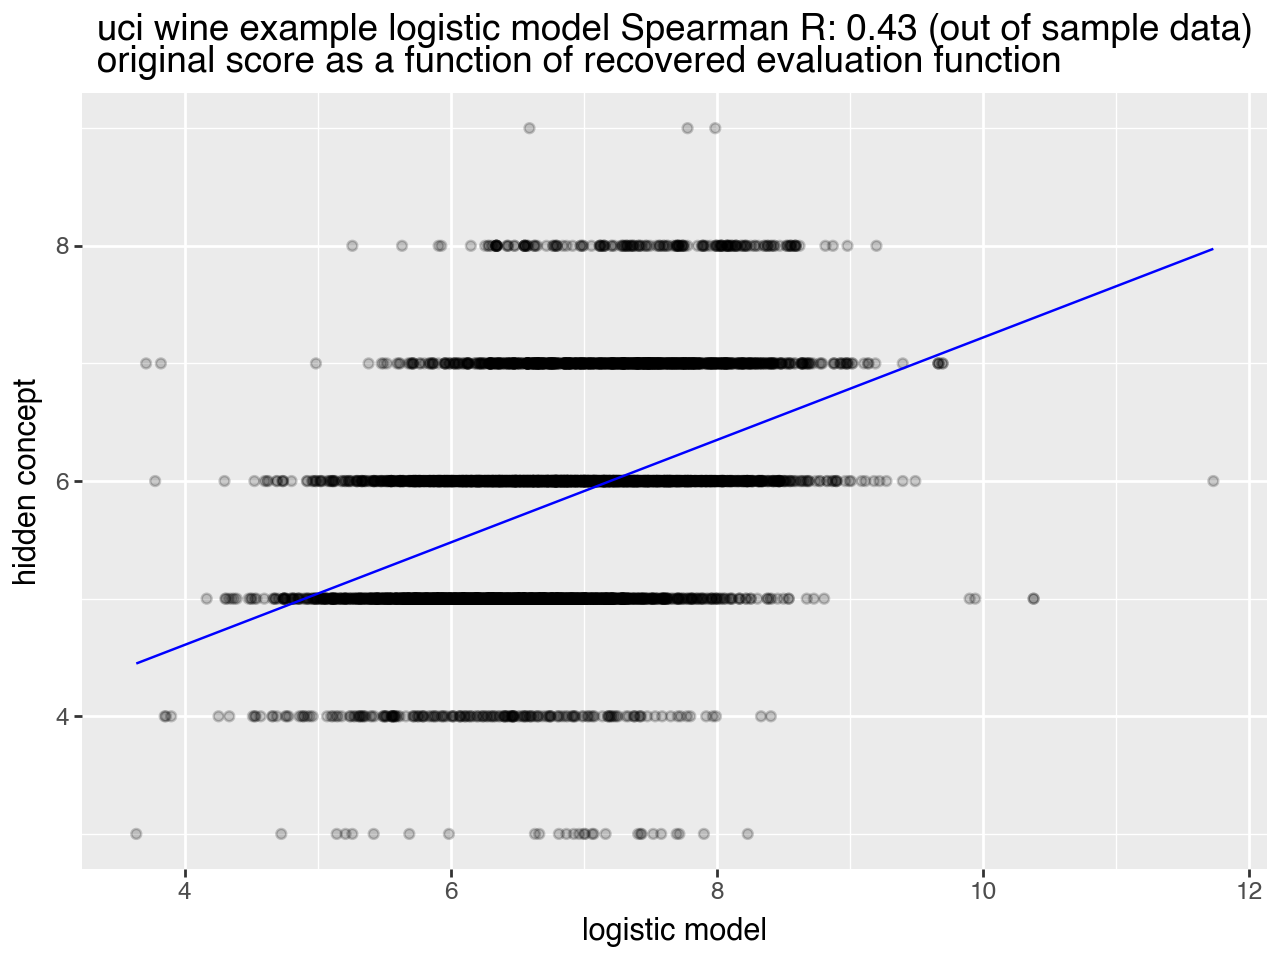

In [35]:
stat_pull = plot_rank_performance(
    estimated_beta=logistic_model.coef_[0],  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="logistic model",  # display name of estimate
    position_quantiles=None,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can also try a related Stan model per-comparison, instead of per-panel.

In [36]:
stan_model_comparison_src = define_Stan_choice_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_comparison_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

In [37]:
fit_comp = run_stan_model(
    stan_model_src=stan_model_comparison_src,
    data_str=data_str,
)

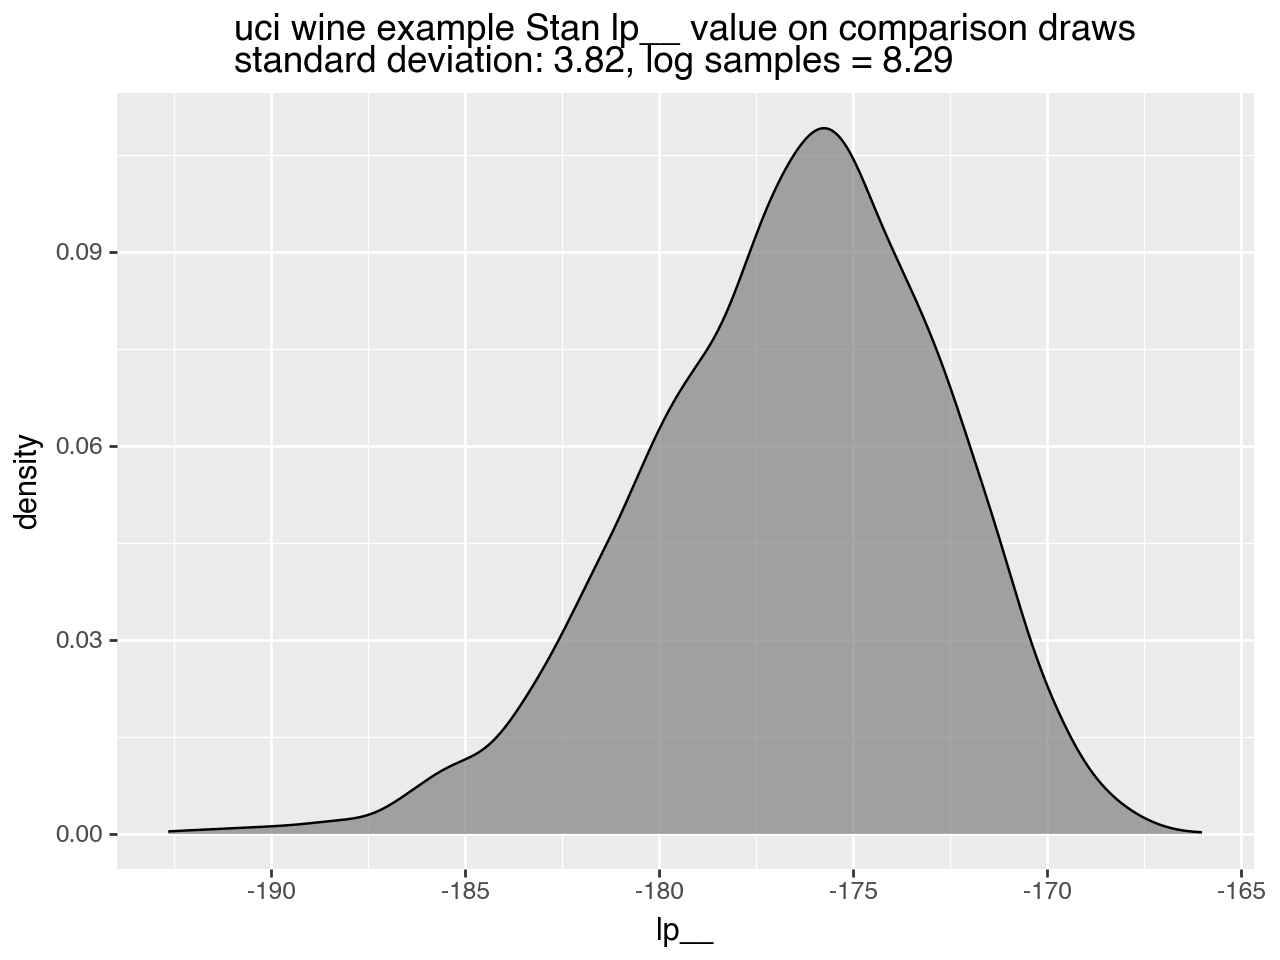

In [38]:
# get implied sample weights from chain
wt_frame_c = fit_comp.draws_pd(vars=["lp__"])
if do_display:
    stddev_c = np.sqrt(np.var(wt_frame_c["lp__"]))
    log_samples_c = np.log(wt_frame_c.shape[0])
    (
        ggplot(
            data=wt_frame_c,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on comparison draws\nstandard deviation: {stddev_c:.2f}, log samples = {log_samples_c:.2f}"
        )
    ).show()

In [39]:
beta_draws_c = fit_comp.draws_pd(vars=["beta"])
estimated_beta_Stan_c = beta_draws_c.loc[
    wt_frame_c["lp__"] >= np.quantile(wt_frame_c["lp__"], 0.9), :
].mean()
# estimated_beta_Stan_c = beta_draws_c.mean()

In [40]:
position_quantiles_c = (
    beta_draws_c.iloc[:, features_frame.shape[1] : n_vars]
    .quantile((0.25, 0.5, 0.75))
    .transpose()
    .reset_index(drop=True, inplace=False)
)
position_quantiles_c.columns = [str(c) for c in position_quantiles_c.columns]

estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,12.959213,-0.0000,10.097850,13.155500,16.321500
1,posn_1,5.162280,-0.7123,2.215253,5.343515,8.518510
2,posn_2,-0.524623,-1.4246,-3.678260,-0.496001,2.709410
3,posn_3,-5.835949,-2.1369,-9.105410,-5.906090,-2.612560
4,posn_4,-12.435606,-2.8492,-15.910500,-12.592650,-9.316212


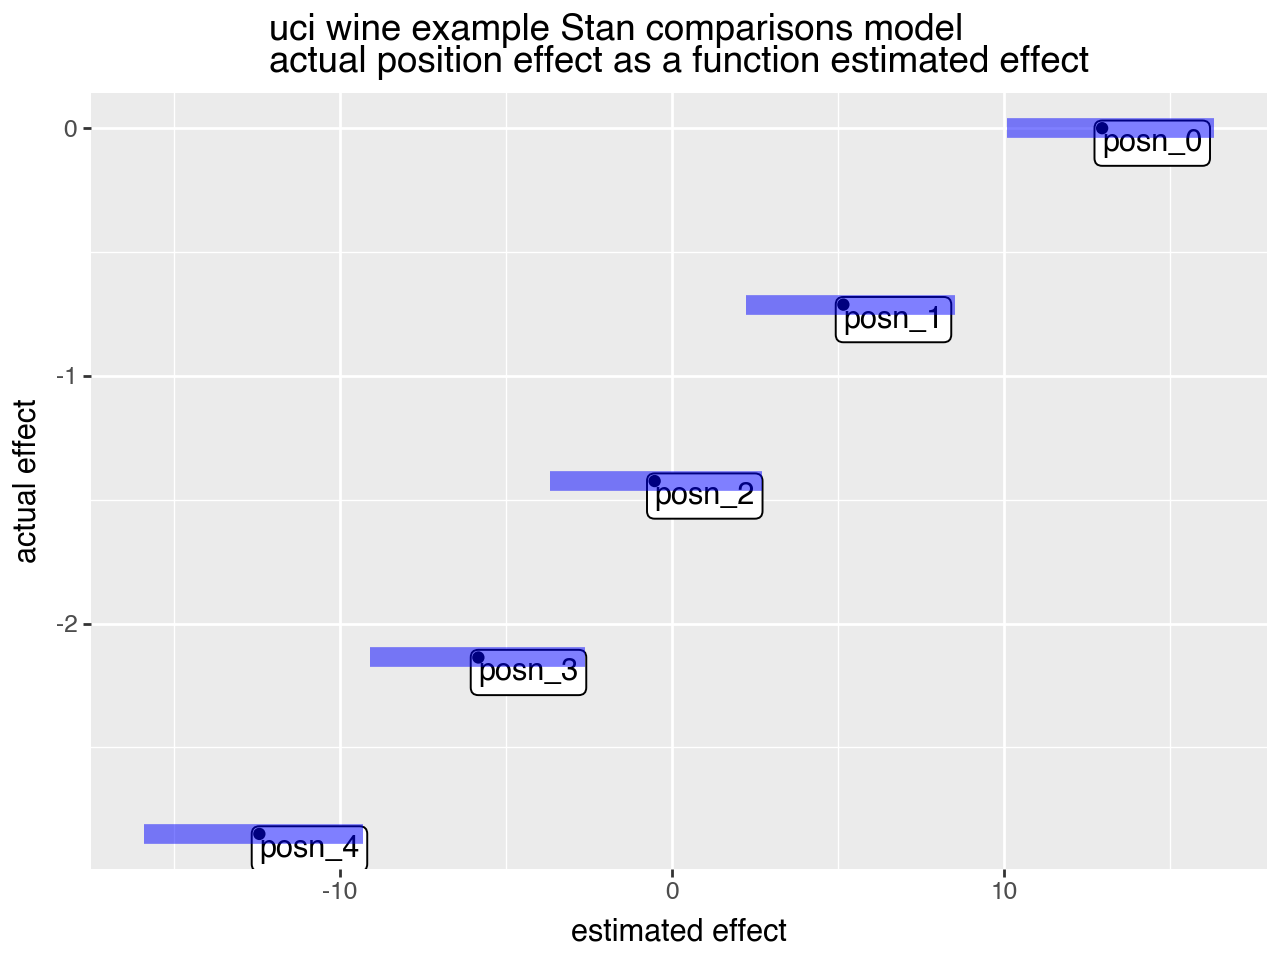

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6643,False
1,0,1,0.1820,False
2,0,2,0.1350,True
3,0,3,0.0170,False
4,0,4,0.0017,False
5,1,0,0.4220,False
6,1,1,0.1857,False
7,1,2,0.1157,True
8,1,3,0.2667,False
9,1,4,0.0099,False


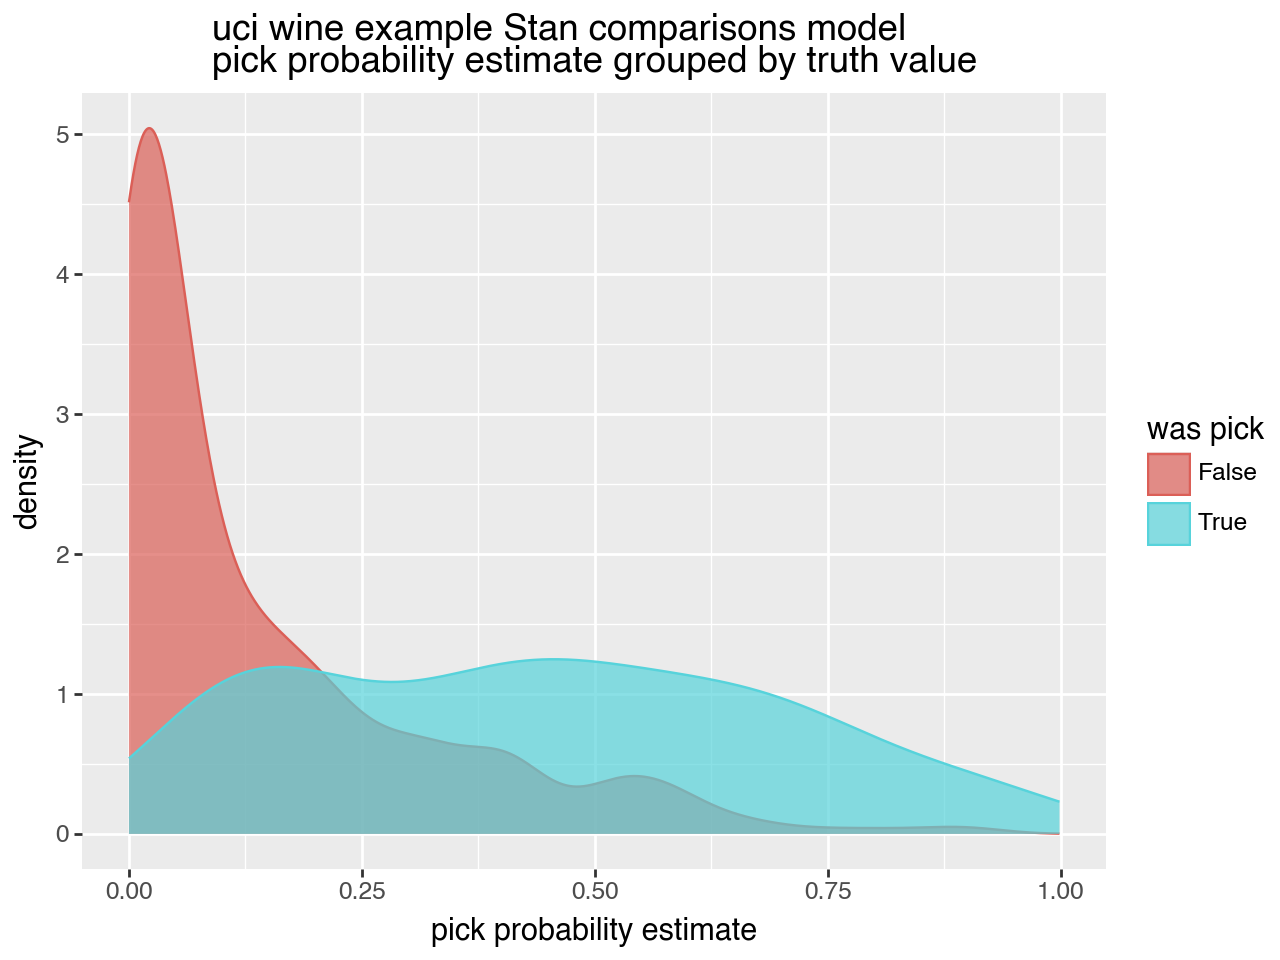

<Figure size 640x480 with 0 Axes>

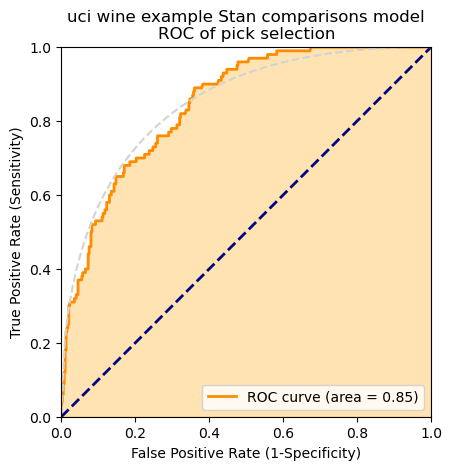

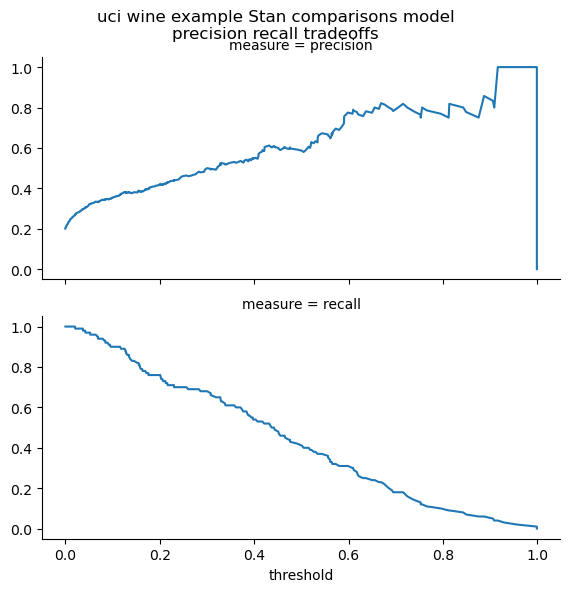

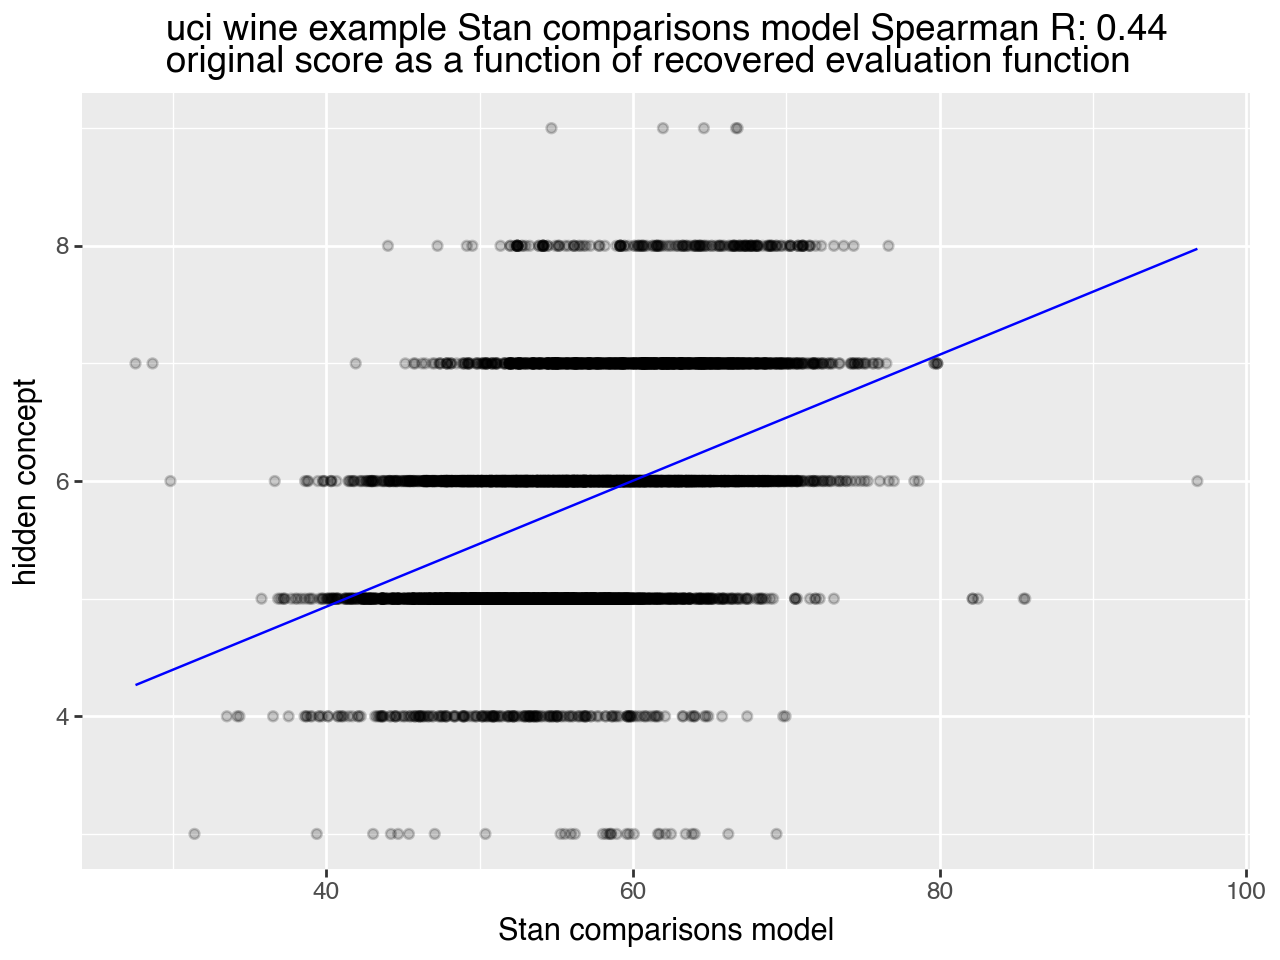

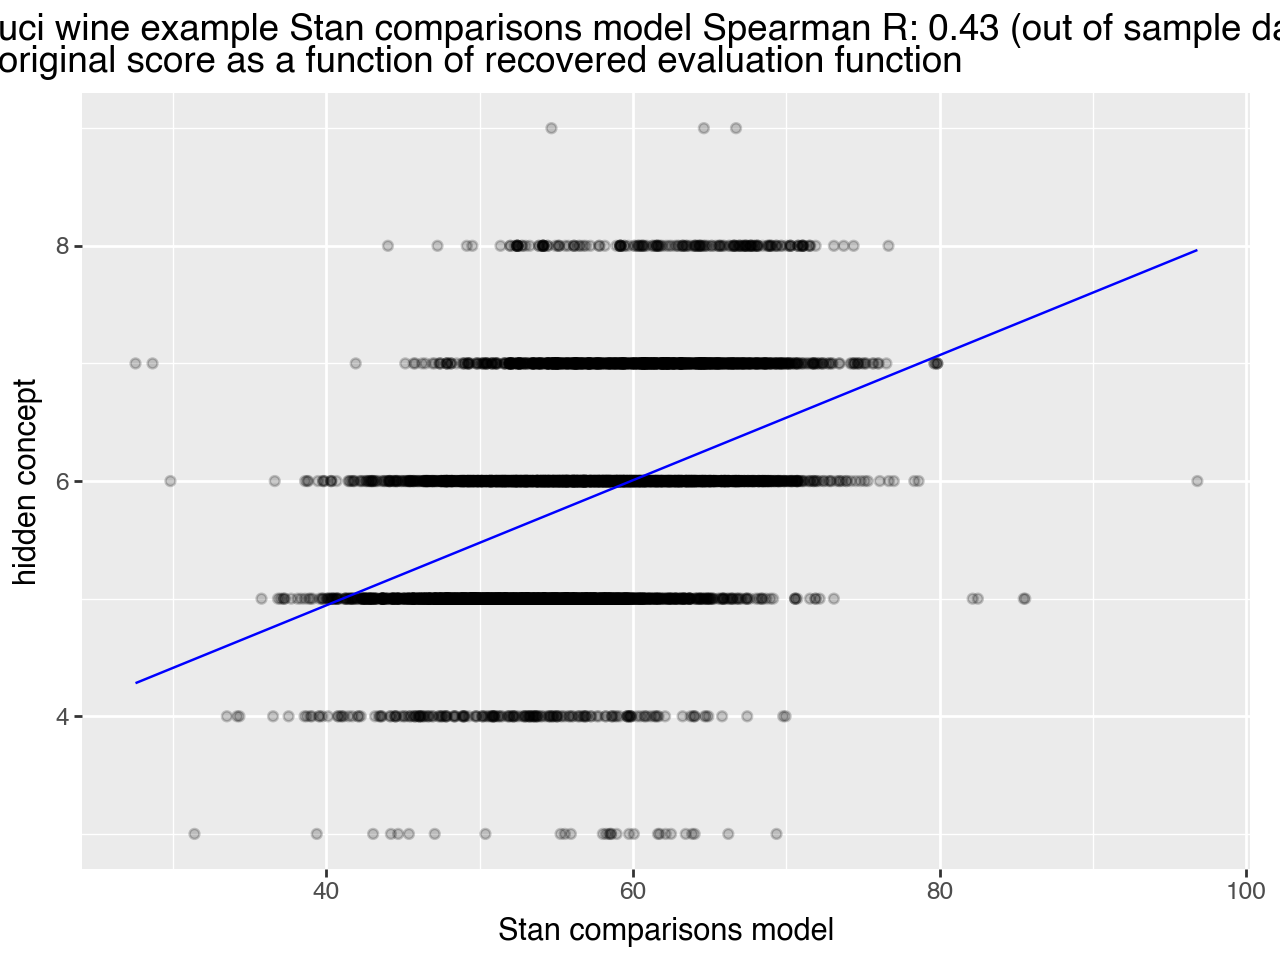

In [41]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan_c,  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="Stan comparisons model",  # display name of estimate
    position_quantiles=position_quantiles_c,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,1.333974,-0.0000,10.097850,13.155500,16.321500
1,posn_1,0.762254,-0.7123,2.215253,5.343515,8.518510
2,posn_2,0.182479,-1.4246,-3.678260,-0.496001,2.709410
3,posn_3,-0.738057,-2.1369,-9.105410,-5.906090,-2.612560
4,posn_4,-1.540650,-2.8492,-15.910500,-12.592650,-9.316212


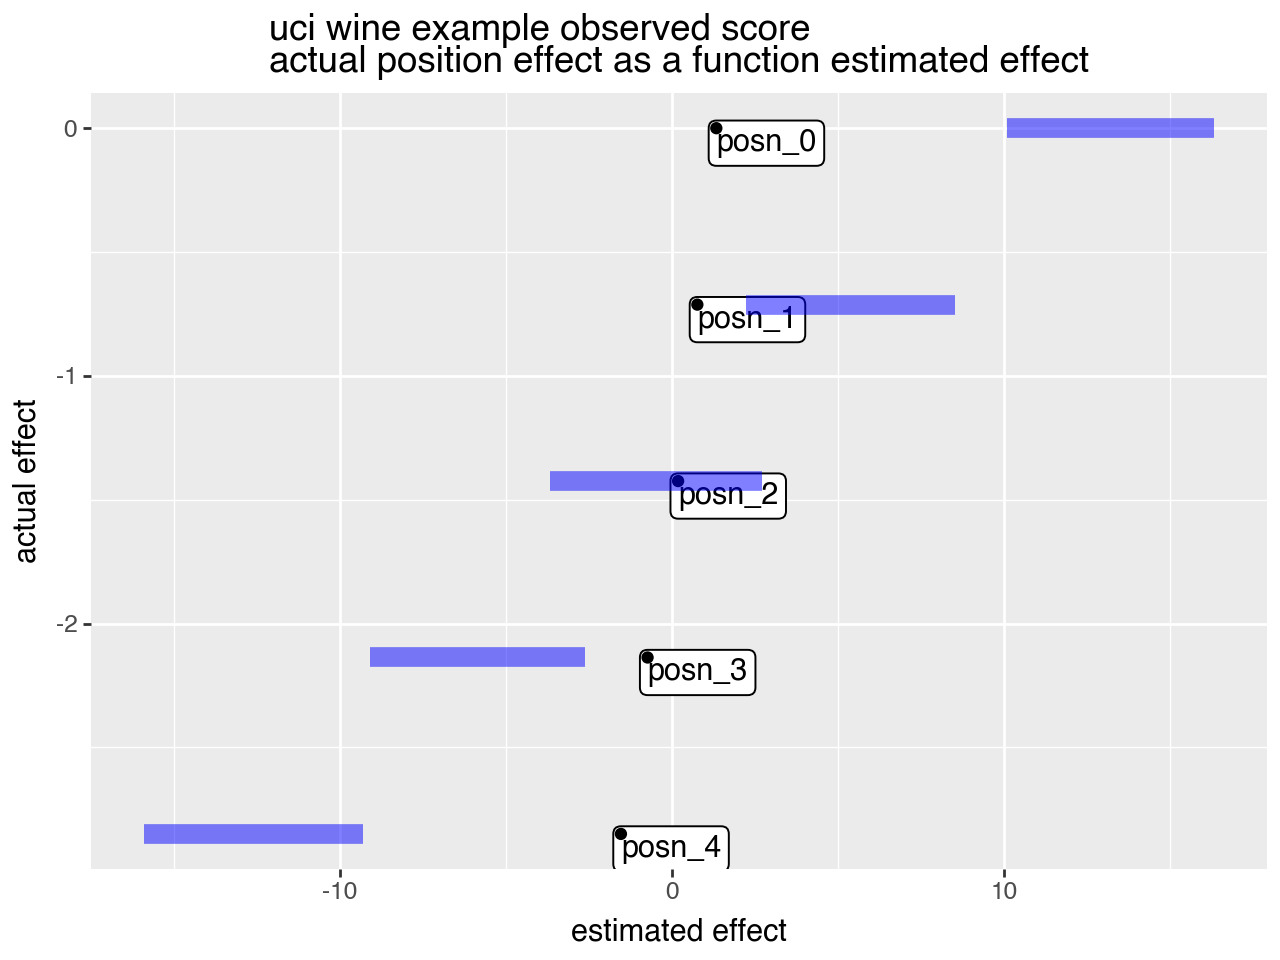

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2447,False
1,0,1,0.2198,False
2,0,2,0.2087,True
3,0,3,0.1713,False
4,0,4,0.1555,False
5,1,0,0.2312,False
6,1,1,0.2181,False
7,1,2,0.2053,True
8,1,3,0.1922,False
9,1,4,0.1532,False


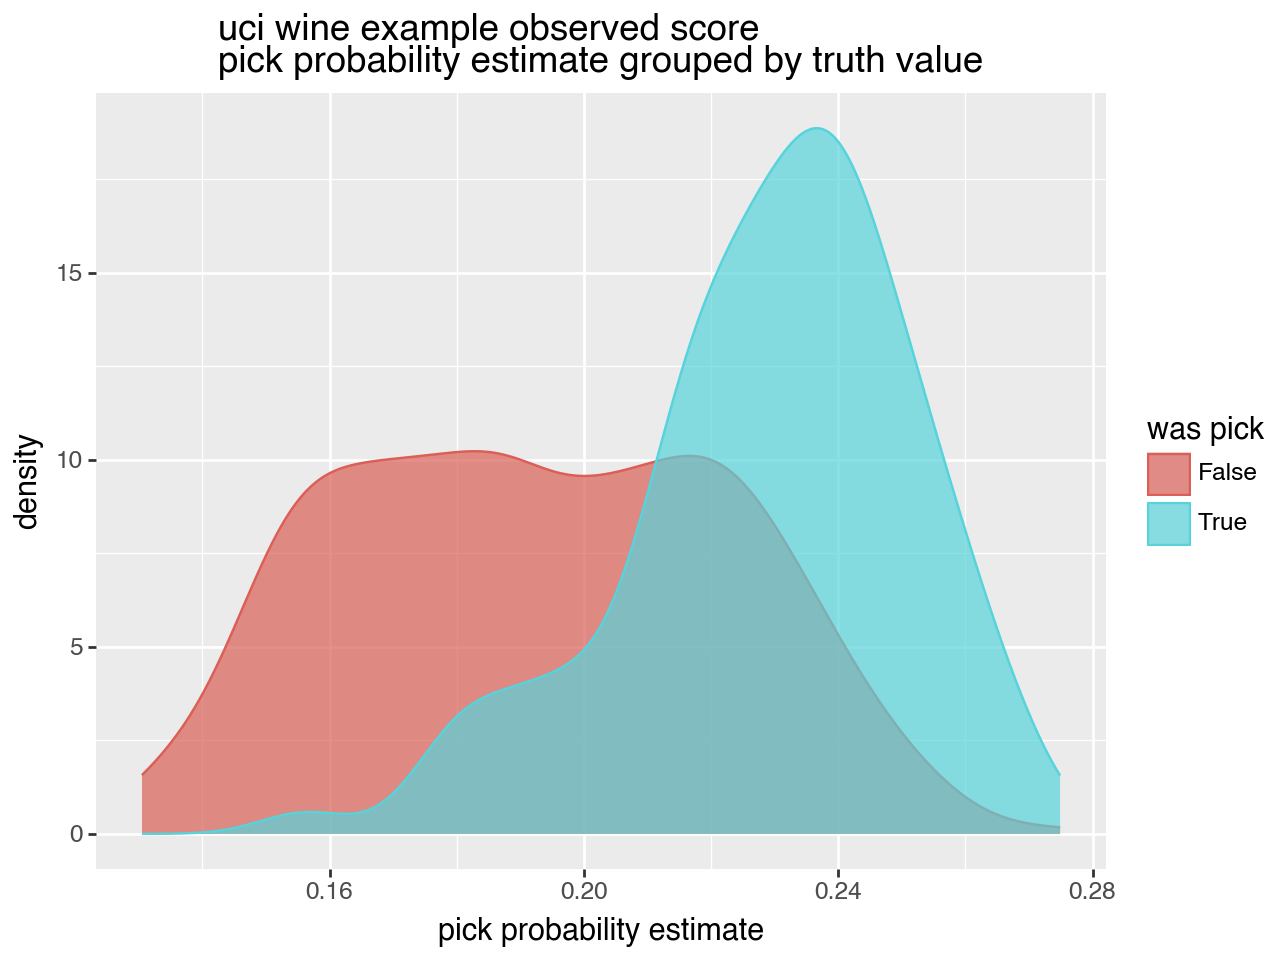

<Figure size 640x480 with 0 Axes>

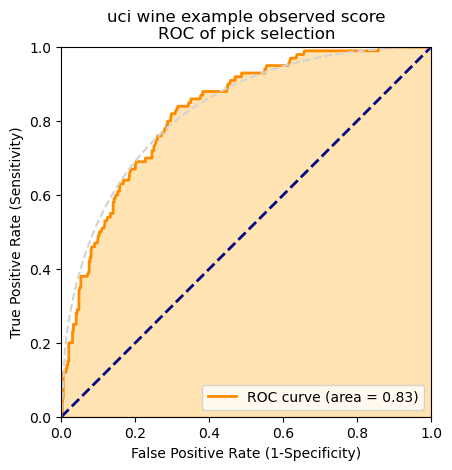

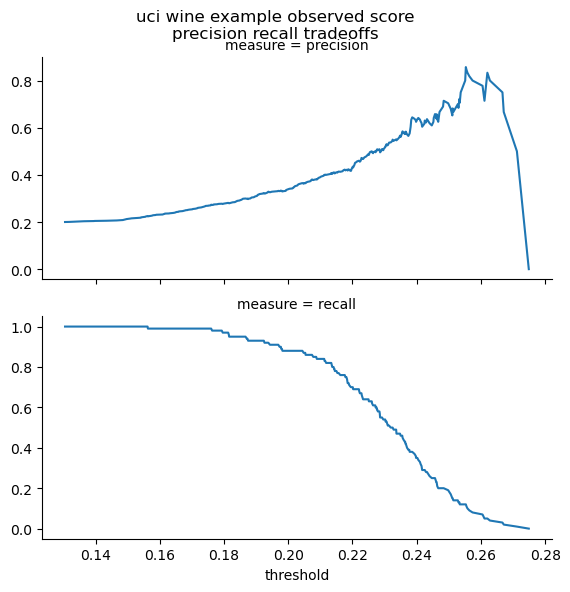

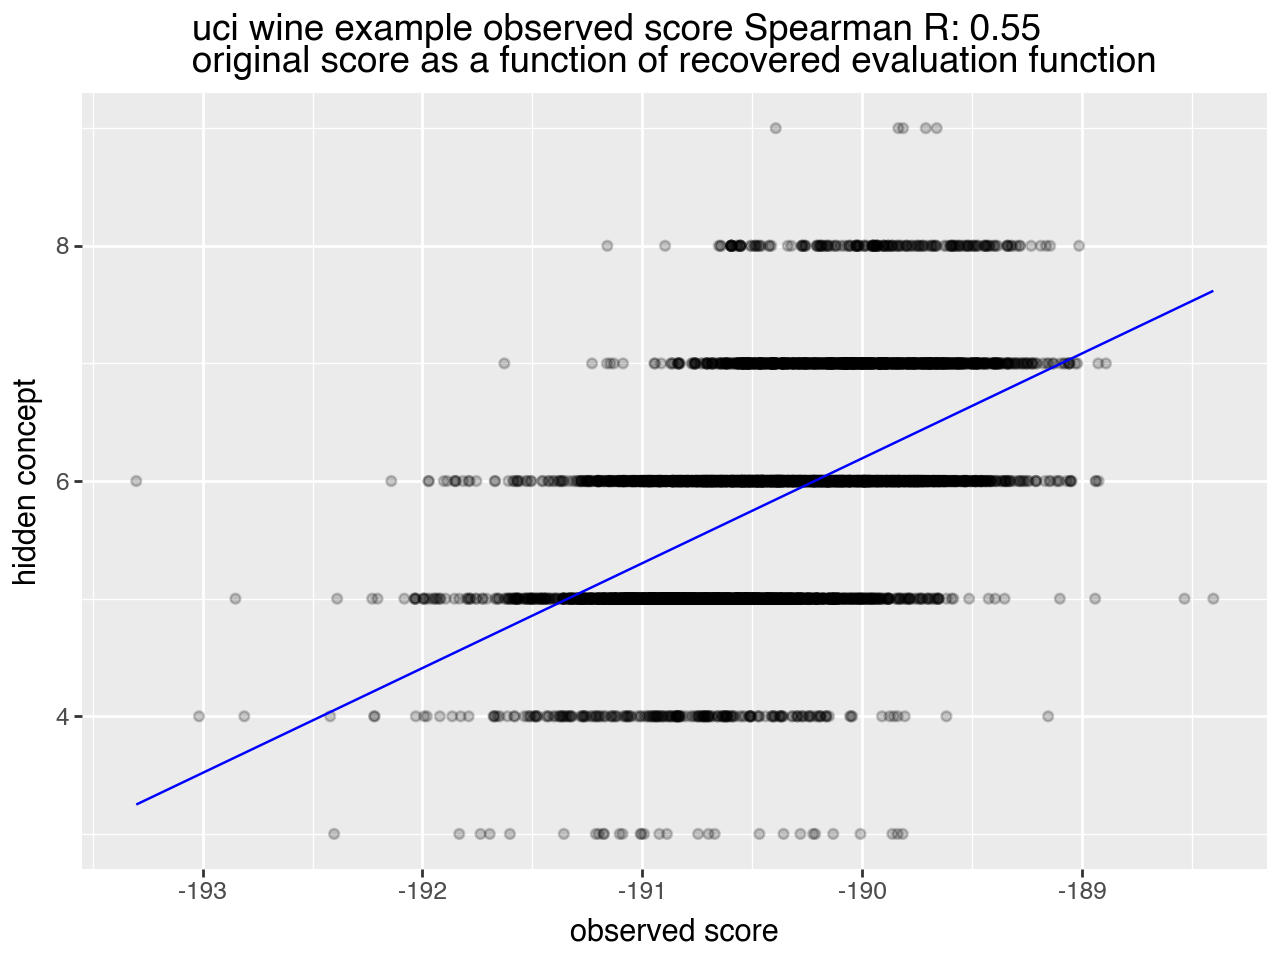

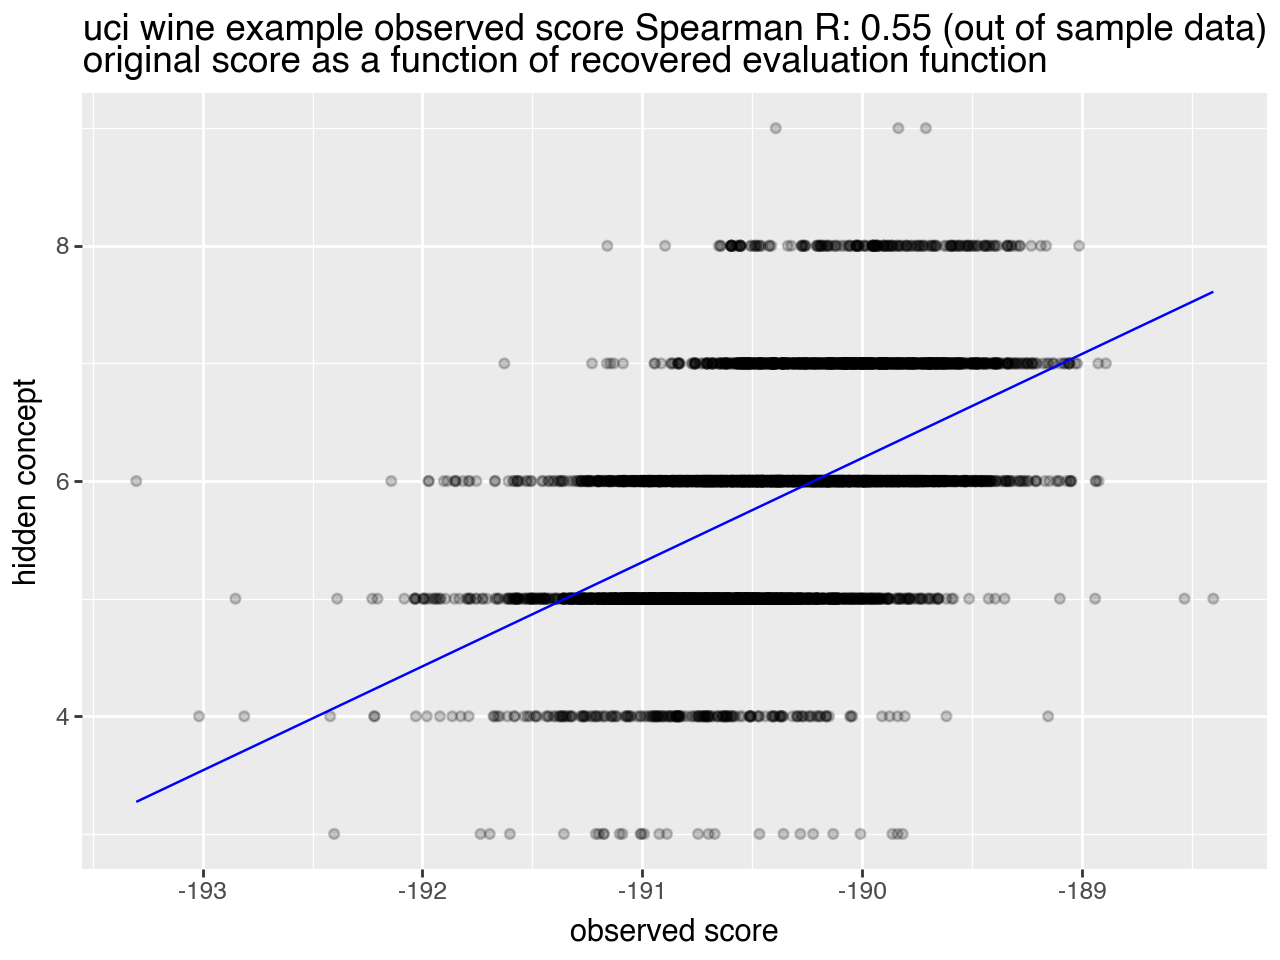

In [42]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        estimated_beta=perfect_coef,  # estimated coefficients
        example_name=example_name,  # name of data set
        n_vars=n_vars,  # number of variables (including position variables)
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations=observations,  # observations layout frame
        estimate_name="observed score",  # display name of estimate
        position_quantiles=position_quantiles_c,  # quantiles of estimated positions
        position_penalties=position_penalties,  # ideal position penalties
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [43]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [44]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [45]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,data_size,test_size
0,uci wine example,Stan panel model,0.429820,0.426814,0.845925,6497,6013
1,uci wine example,logistic model,0.434607,0.431649,0.846975,6497,6013
2,uci wine example,Stan comparisons model,0.437476,0.434346,0.845862,6497,6013
3,uci wine example,observed score,0.551482,0.549029,0.828175,6497,6013
